# Stochastic Phytoplankton Dynamics

## Deterministic case

In order to reproduce the original Ventrella et al. result, we simulate the original deterministic equations:


$$\begin{align*}
\dot{x} &= \alpha e^{z}\cos(x-t) + \sigma(\beta+z) + \nu \sin \phi \\[0.2cm]
\dot{z} &= \alpha e^{z}\sin(x-t) + \nu \cos \phi \\[0.2cm]
\dot{\phi} &= \lambda\alpha e^{z}\cos(x-t+2\phi) + \frac{\sigma}{2}(1+\lambda \cos 2\phi)
\end{align*}$$


with RK4 and numpa.

In [20]:
import numpy as np
import time
from numba import njit, prange

sig = 0.001
bet = 100
lam = 0.6
alf = 0.1
v0 = 0.01
tn = 10000
dt = 0.01

zs = np.array([-1.0, -2.0, -3.0, -4.0, -5.0], dtype=np.float32)
n_conds = len(zs)
x0, p0 = 0.0, -0.5 * np.pi

T = np.arange(0.0, tn + 1e-6, dt, dtype=np.float32)
N = len(T)

@njit(fastmath=True)
def calc(x, z, p, t, lam, alf, sig, bet, v0):
    ez = np.exp(z)
    pd = x - t
    dp = (lam * alf * ez * np.cos(pd + 2*p) + 0.5 * sig * (1 + lam * np.cos(2*p)))
    dx = (alf * ez * np.cos(pd) + v0 * np.sin(p) + sig * (bet + z))
    dz = (alf * ez * np.sin(pd) + v0 * np.cos(p))
    return dx, dz, dp

@njit(parallel=True, fastmath=True)
def sim(n, N, T, dt, zs, lam, alf, sig, bet, v0):
    X = np.zeros((n, N), dtype=np.float32)
    Z = np.zeros((n, N), dtype=np.float32)
    P = np.zeros((n, N), dtype=np.float32)
    L = np.full(n, N, dtype=np.int64)
    
    clam = np.float32(lam)
    calf = np.float32(alf)
    csig = np.float32(sig)
    cbet = np.float32(bet)
    cv0 = np.float32(v0)
    
    dt2 = np.float32(dt / 2.0)
    dt6 = np.float32(dt / 6.0)

    for i in prange(n):
        cx = np.float32(x0)
        cz = zs[i]
        cp = np.float32(p0)
        
        X[i, 0], Z[i, 0], P[i, 0] = cx, cz, cp
        
        for j in range(N - 1):
            tj = T[j]
            
            k1x, k1z, k1p = calc(cx, cz, cp, tj, clam, calf, csig, cbet, cv0)
            k2x, k2z, k2p = calc(cx + k1x * dt2, cz + k1z * dt2, cp + k1p * dt2, tj + dt2, clam, calf, csig, cbet, cv0)
            k3x, k3z, k3p = calc(cx + k2x * dt2, cz + k2z * dt2, cp + k2p * dt2, tj + dt2, clam, calf, csig, cbet, cv0)
            k4x, k4z, k4p = calc(cx + k3x * dt, cz + k3z * dt, cp + k3p * dt, tj + dt, clam, calf, csig, cbet, cv0)
            
            nx = cx + dt6 * (k1x + 2*k2x + 2*k3x + k4x)
            nz = cz + dt6 * (k1z + 2*k2z + 2*k3z + k4z)
            npdet = cp + dt6 * (k1p + 2*k2p + 2*k3p + k4p)
            
            X[i, j+1] = nx
            Z[i, j+1] = nz
            P[i, j+1] = npdet
            
            cx, cz, cp = nx, nz, npdet
            
            if cz > 0.0 or cz < -6.0:
                L[i] = j + 2
                break
                
    return X, Z, P, L

t1 = time.time()
rX, rZ, rP, L = sim(n_conds, N, T, np.float32(dt), zs, np.float32(lam), np.float32(alf), np.float32(sig), np.float32(bet), np.float32(v0))
print(f"Time: {time.time() - t1:.4f}s")

np.savez_compressed('deterministic_phyto.npz', t=T, x=rX, z=rZ, p=rP, l=L, z_in=zs)

Time: 5.0723s


Saved 'Deterministic_phyto.pdf'


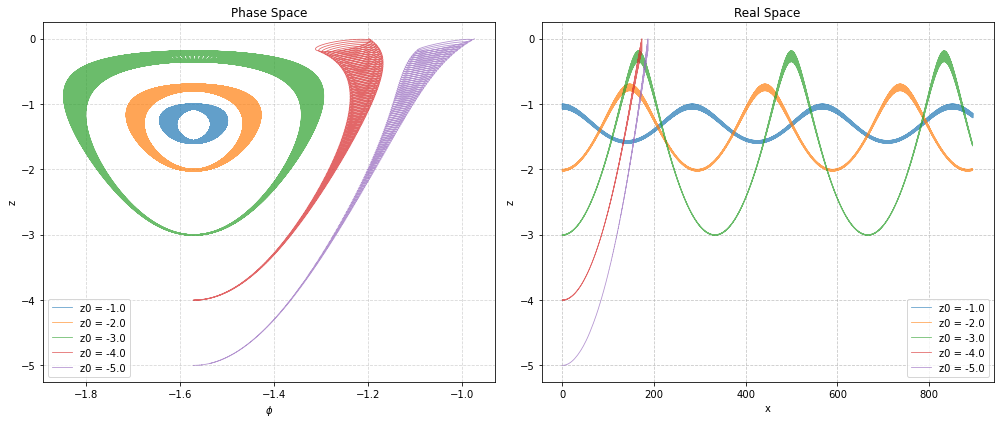

In [21]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'deterministic_phyto.npz'

try:
    d = np.load(filename)
    T = d['t']
    X = d['x']
    Z = d['z']
    P = d['p']
    L = d['l']
    zs = d['z_in']
except FileNotFoundError:
    print(f"Error: Could not find '{filename}'. Make sure the simulation cell ran successfully.")
    raise

limit = 100000
total_pts = len(T)
skip = max(1, total_pts // limit)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
#colors = plt.cm.tab10(np.linspace(0, 1, len(zs)))

for i in range(len(zs)):
    idx = L[i]
    if idx > 1:
        # Access the i-th simulation first, THEN slice it
        fX = X[i][:idx:skip]
        fZ = Z[i][:idx:skip]
        fP = P[i][:idx:skip]
        
        lbl = f"z0 = {zs[i]:.1f}"
        
        #ax1.plot(fP, fZ, lw=0.8, alpha=0.7, color=colors[i], label=lbl)
        #ax2.plot(fX, fZ, lw=0.8, alpha=0.7, color=colors[i], label=lbl)
        
        ax1.plot(fP, fZ, lw=0.8, alpha=0.7, label=lbl)
        ax2.plot(fX, fZ, lw=0.8, alpha=0.7, label=lbl)

ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel('z')
ax1.set_title('Phase Space')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_title('Real Space')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.savefig('Deterministic_phyto.pdf', dpi=300)
print("Saved 'Deterministic_phyto.pdf'")
plt.show()

Exactly reproduced Ventrella et al.

## Stochastic Case

We will now add a stochastic term to the angle.

$$\begin{align*}
\dot{x} &= \alpha e^{z}\cos(x-t) + \sigma(\beta+z) + \nu \sin \phi \\[0.2cm]
\dot{z} &= \alpha e^{z}\sin(x-t) + \nu \cos \phi \\[0.2cm]
\dot{\phi} &= \lambda\alpha e^{z}\cos(x-t+2\phi) + \frac{\sigma}{2}(1+\lambda \cos 2\phi) + \sqrt{2D} \xi(t)
\end{align*}$$

#### Numerical Integration Scheme: Euler-Maruyama
For the stochastic simulations, we adopt the **Euler-Maruyama** integration scheme instead of the 4th-order Runge-Kutta (RK4) used in the deterministic section.

While RK4 provides higher accuracy for deterministic equations ($O(\Delta t^4)$), this advantage diminishes significantly in the presence of Brownian motion due to the non-differentiable nature of the noise term. For Stochastic Differential Equations (SDEs), standard RK4 does not converge to the correct stochastic solution order without complex modifications.

Furthermore, since the noise term in our model is **additive** (the diffusion coefficient $D_r$ is independent of the state variables $x, z, \phi$), the Euler-Maruyama scheme is robust and coincides with higher-order methods like the Milstein scheme. Given our focus on the **weak convergence** (statistical properties and distributions of the ensemble) rather than the precise pathwise evolution of single particles, Euler-Maruyama with a time step of $dt=0.1$ offers the best trade-off between computational efficiency and statistical accuracy.

#### Parameter Tuning and Initial Conditions
Before performing the extensive statistical averaging presented below, a preliminary exploratory analysis was conducted. Various diffusion coefficients ($D_r$) and initial conditions were tested to examine the general behavior of the system.

Through these trials (not shown here for brevity), we identified an ideal diffusion coefficient and a set of initial conditions that best reproduce the dynamics observed in nature. The following simulations utilize these optimized parameters to ensure physical realism.

### D = 0.00001

#### Simulation Constraints and Boundary Conditions
The simulation incorporates specific boundary conditions to reflect the physical constraints of the environment. The trajectories are computed subject to two critical limits on the vertical position $z$:

1.  **Upper Bound ($z > 0$):** This represents the water surface. Since phytoplankton cannot physically exist above the surface, any trajectory crossing $z=0$ is considered unphysical and is discarded from the ensemble.
2.  **Lower Bound ($z < -6$):** This threshold marks the bottom of the mixed layer. Particles reaching this depth are considered to have exited the layer of interest and are removed from the active population.

We perform averages over 1000 valid trajectories to ensure statistical significance.

#### t = 10000

In [4]:
import numpy as np
import time
from numba import njit, prange
import gc

Dr = 0.00001
sig = 0.001
bet = 100
lam = 0.6
alf = 0.1
v0 = 0.01
tn = 10000
dt = 0.1
target = 1000
x0, z0, p0 = 0.0, -2.0, -0.5 * np.pi
step = 10
bsize = 1500

T = np.arange(0.0, tn + 1e-6, dt, dtype=np.float32)
N = len(T)
sT = T[::step]

@njit(parallel=True, fastmath=True)
def sim(n, N, T, dt, Dr, lam, alf, sig, bet, v0):
    X = np.zeros((n, N), dtype=np.float32)
    Z = np.zeros((n, N), dtype=np.float32)
    P = np.zeros((n, N), dtype=np.float32)
    L = np.full(n, N, dtype=np.int64)
    sqdt = np.float32(np.sqrt(2 * Dr * dt))
    
    clam = np.float32(lam)
    calf = np.float32(alf)
    csig = np.float32(sig)
    cbet = np.float32(bet)
    cv0  = np.float32(v0)
    
    for i in prange(n):
        cx = np.float32(x0)
        cz = np.float32(z0)
        cp = np.float32(p0)
        
        X[i, 0], Z[i, 0], P[i, 0] = cx, cz, cp
        
        for j in range(N - 1):
            ez = np.exp(cz)
            pd = cx - T[j]
            noi = sqdt * np.float32(np.random.standard_normal())
            
            npdt = cp + (clam*calf*ez*np.cos(pd + 2*cp) + 0.5*csig*(1 + clam*np.cos(2*cp)))*dt + noi
            nx = cx + (calf*ez*np.cos(pd) + cv0*np.sin(cp) + csig*(cbet + cz))*dt
            nz = cz + (calf*ez*np.sin(pd) + cv0*np.cos(cp))*dt
            
            X[i, j+1] = nx
            Z[i, j+1] = nz
            P[i, j+1] = npdt
            
            cx, cz, cp = nx, nz, npdt
            
            if cz > 0.0 or cz < -6.0:
                L[i] = j + 2
                break
                
    return X, Z, P, L

lX, lZ, lP = [], [], []
found = 0

print(f"Start Sim (z0={z0}, fixed batch={bsize})")
t1 = time.time()

while found < target:
    gc.collect()
    print(f"Running batch...", end=" ")
    
    rX, rZ, rP, rL = sim(bsize, N, T, np.float32(dt), np.float32(Dr), 
                         np.float32(lam), np.float32(alf), np.float32(sig), 
                         np.float32(bet), np.float32(v0))
    
    surv = np.where(rL == N)[0]
    ns = len(surv)
    need = target - found
    take = surv[:need]
    
    for idx in take:
        lX.append(rX[idx][::step])
        lZ.append(rZ[idx][::step])
        lP.append(rP[idx][::step])
        
    found += len(take)
    print(f"Surv: {ns}. Tot: {found}/{target}")
    
    del rX, rZ, rP, rL

fX = np.array(lX)
fZ = np.array(lZ)
fP = np.array(lP)

np.savez_compressed('stochastic_t1.npz', t=sT, x=fX, z=fZ, p=fP)
print(f"Done. Time: {time.time()-t1:.2f}s")

Start Sim (z0=-2.0, fixed batch=1500)
Running batch... Surv: 567. Tot: 567/1000
Running batch... Surv: 586. Tot: 1000/1000
Done. Time: 20.91s


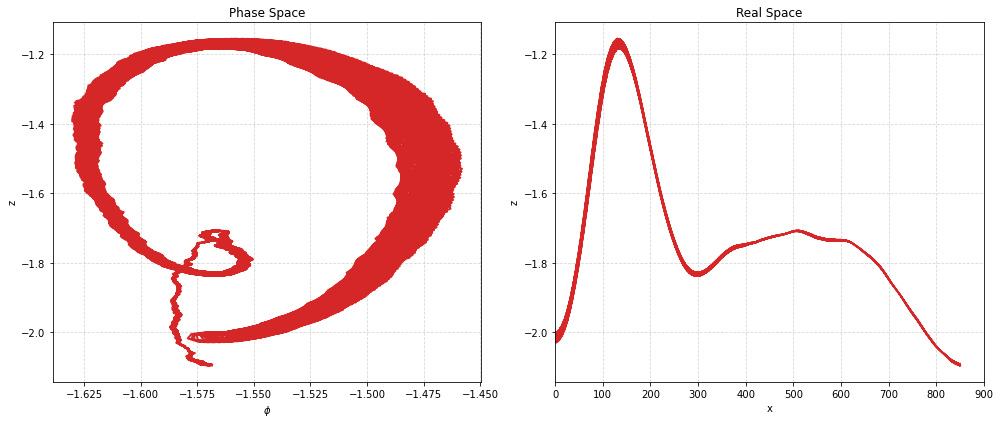

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fn = 'stochastic_t1.npz'

try:
    d = np.load(fn)
    X = d['x']
    Z = d['z']
    P = d['p']
except FileNotFoundError:
    exit()

mX = np.mean(X, axis=0)
mZ = np.mean(Z, axis=0)
mP = np.mean(P, axis=0)

xlim = 850
msk = mX <= xlim

cX = mX[msk]
cZ = mZ[msk]
cP = mP[msk]

tgt = 50000
sk = max(1, len(cX) // tgt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(cP[::sk], cZ[::sk], c='#d62728', lw=2)
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel('z')
ax1.set_title('Phase Space')
ax1.grid(True, ls='--', alpha=0.5)

ax2.plot(cX[::sk], cZ[::sk], c='#d62728', lw=2)
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_xlim(0, xlim + 50)
ax2.set_title(f'Real Space')
ax2.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.savefig('t1Stochastic_Phyto.pdf', dpi=300)
plt.show()

#### t = 20000

In [6]:
import numpy as np
import time
from numba import njit, prange
import gc

Dr = 0.00001
sig = 0.001
bet = 100
lam = 0.6
alf = 0.1
v0 = 0.01
tn = 20000
dt = 0.1
target = 1000
x0, z0, p0 = 0.0, -2.0, -0.5 * np.pi
step = 10
bsize = 1500

T = np.arange(0.0, tn + 1e-6, dt, dtype=np.float32)
N = len(T)
sT = T[::step]

@njit(parallel=True, fastmath=True)
def sim(n, N, T, dt, Dr, lam, alf, sig, bet, v0):
    X = np.zeros((n, N), dtype=np.float32)
    Z = np.zeros((n, N), dtype=np.float32)
    P = np.zeros((n, N), dtype=np.float32)
    L = np.full(n, N, dtype=np.int64)
    sqdt = np.float32(np.sqrt(2 * Dr * dt))
    
    clam = np.float32(lam)
    calf = np.float32(alf)
    csig = np.float32(sig)
    cbet = np.float32(bet)
    cv0  = np.float32(v0)
    
    for i in prange(n):
        cx = np.float32(x0)
        cz = np.float32(z0)
        cp = np.float32(p0)
        
        X[i, 0], Z[i, 0], P[i, 0] = cx, cz, cp
        
        for j in range(N - 1):
            ez = np.exp(cz)
            pd = cx - T[j]
            noi = sqdt * np.float32(np.random.standard_normal())
            
            npdt = cp + (clam*calf*ez*np.cos(pd + 2*cp) + 0.5*csig*(1 + clam*np.cos(2*cp)))*dt + noi
            nx = cx + (calf*ez*np.cos(pd) + cv0*np.sin(cp) + csig*(cbet + cz))*dt
            nz = cz + (calf*ez*np.sin(pd) + cv0*np.cos(cp))*dt
            
            X[i, j+1] = nx
            Z[i, j+1] = nz
            P[i, j+1] = npdt
            
            cx, cz, cp = nx, nz, npdt
            
            if cz > 0.0 or cz < -6.0:
                L[i] = j + 2
                break
                
    return X, Z, P, L

lX, lZ, lP = [], [], []
found = 0

print(f"Start Sim (z0={z0}, fixed batch={bsize})")
t1 = time.time()

while found < target:
    gc.collect()
    print(f"Running batch...", end=" ")
    
    rX, rZ, rP, rL = sim(bsize, N, T, np.float32(dt), np.float32(Dr), 
                         np.float32(lam), np.float32(alf), np.float32(sig), 
                         np.float32(bet), np.float32(v0))
    
    surv = np.where(rL == N)[0]
    ns = len(surv)
    need = target - found
    take = surv[:need]
    
    for idx in take:
        lX.append(rX[idx][::step])
        lZ.append(rZ[idx][::step])
        lP.append(rP[idx][::step])
        
    found += len(take)
    print(f"Surv: {ns}. Tot: {found}/{target}")
    
    del rX, rZ, rP, rL

fX = np.array(lX)
fZ = np.array(lZ)
fP = np.array(lP)

np.savez_compressed('stochastic_t2.npz', t=sT, x=fX, z=fZ, p=fP)
print(f"Done. Time: {time.time()-t1:.2f}s")

Start Sim (z0=-2.0, fixed batch=1500)
Running batch... Surv: 150. Tot: 150/1000
Running batch... Surv: 151. Tot: 301/1000
Running batch... Surv: 147. Tot: 448/1000
Running batch... Surv: 121. Tot: 569/1000
Running batch... Surv: 121. Tot: 690/1000
Running batch... Surv: 142. Tot: 832/1000
Running batch... Surv: 139. Tot: 971/1000
Running batch... Surv: 153. Tot: 1000/1000
Done. Time: 74.25s


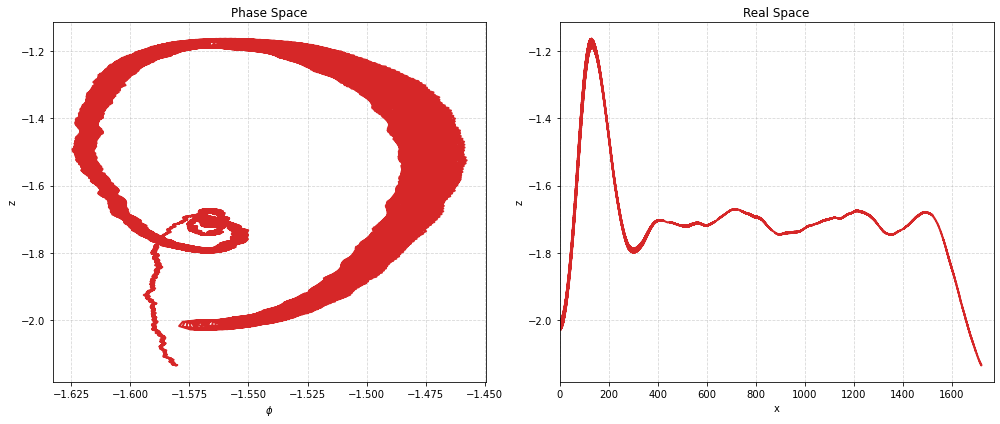

In [23]:
import numpy as np
import matplotlib.pyplot as plt

fn = 'stochastic_t2.npz'

try:
    d = np.load(fn)
    X = d['x']
    Z = d['z']
    P = d['p']
except FileNotFoundError:
    exit()

mX = np.mean(X, axis=0)
mZ = np.mean(Z, axis=0)
mP = np.mean(P, axis=0)

xlim = 1720
msk = mX <= xlim

cX = mX[msk]
cZ = mZ[msk]
cP = mP[msk]

tgt = 50000
sk = max(1, len(cX) // tgt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(cP[::sk], cZ[::sk], c='#d62728', lw=2)
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel('z')
ax1.set_title('Phase Space')
ax1.grid(True, ls='--', alpha=0.5)

ax2.plot(cX[::sk], cZ[::sk], c='#d62728', lw=2)
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_xlim(0, xlim + 50)
ax2.set_title(f'Real Space')
ax2.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.savefig('t2Stochastic_Phyto.pdf', dpi=300)
plt.show()

#### t = 30000

In [8]:
import numpy as np
import time
from numba import njit, prange
import gc

Dr = 0.00001
sig = 0.001
bet = 100
lam = 0.6
alf = 0.1
v0 = 0.01
tn = 30000
dt = 0.1
target = 1000
x0, z0, p0 = 0.0, -2.0, -0.5 * np.pi
step = 10
bsize = 500

T = np.arange(0.0, tn + 1e-6, dt, dtype=np.float32)
N = len(T)
sT = T[::step]

@njit(parallel=True, fastmath=True)
def sim(n, N, T, dt, Dr, lam, alf, sig, bet, v0):
    X = np.zeros((n, N), dtype=np.float32)
    Z = np.zeros((n, N), dtype=np.float32)
    P = np.zeros((n, N), dtype=np.float32)
    L = np.full(n, N, dtype=np.int64)
    sqdt = np.float32(np.sqrt(2 * Dr * dt))
    
    clam = np.float32(lam)
    calf = np.float32(alf)
    csig = np.float32(sig)
    cbet = np.float32(bet)
    cv0  = np.float32(v0)
    
    for i in prange(n):
        cx = np.float32(x0)
        cz = np.float32(z0)
        cp = np.float32(p0)
        
        X[i, 0], Z[i, 0], P[i, 0] = cx, cz, cp
        
        for j in range(N - 1):
            ez = np.exp(cz)
            pd = cx - T[j]
            noi = sqdt * np.float32(np.random.standard_normal())
            
            npdt = cp + (clam*calf*ez*np.cos(pd + 2*cp) + 0.5*csig*(1 + clam*np.cos(2*cp)))*dt + noi
            nx = cx + (calf*ez*np.cos(pd) + cv0*np.sin(cp) + csig*(cbet + cz))*dt
            nz = cz + (calf*ez*np.sin(pd) + cv0*np.cos(cp))*dt
            
            X[i, j+1] = nx
            Z[i, j+1] = nz
            P[i, j+1] = npdt
            
            cx, cz, cp = nx, nz, npdt
            
            if cz > 0.0 or cz < -6.0:
                L[i] = j + 2
                break
                
    return X, Z, P, L

lX, lZ, lP = [], [], []
found = 0

print(f"Start Sim (tn={tn}, bsize={bsize})")
t1 = time.time()

while found < target:
    gc.collect()
    print(f"Running batch...", end=" ")
    
    rX, rZ, rP, rL = sim(bsize, N, T, np.float32(dt), np.float32(Dr), 
                         np.float32(lam), np.float32(alf), np.float32(sig), 
                         np.float32(bet), np.float32(v0))
    
    surv = np.where(rL == N)[0]
    ns = len(surv)
    need = target - found
    take = surv[:need]
    
    for idx in take:
        lX.append(rX[idx][::step].copy())
        lZ.append(rZ[idx][::step].copy())
        lP.append(rP[idx][::step].copy())
        
    found += len(take)
    print(f"Surv: {ns}. Tot: {found}/{target}")
    
    del rX, rZ, rP, rL
    time.sleep(0.1)

fX = np.array(lX)
fZ = np.array(lZ)
fP = np.array(lP)

np.savez_compressed('stochastic_t3.npz', t=sT, x=fX, z=fZ, p=fP)
print(f"Done. Time: {time.time()-t1:.2f}s")

Start Sim (tn=30000, bsize=500)
Running batch... Surv: 11. Tot: 11/1000
Running batch... Surv: 8. Tot: 19/1000
Running batch... Surv: 13. Tot: 32/1000
Running batch... Surv: 10. Tot: 42/1000
Running batch... Surv: 12. Tot: 54/1000
Running batch... Surv: 10. Tot: 64/1000
Running batch... Surv: 13. Tot: 77/1000
Running batch... Surv: 10. Tot: 87/1000
Running batch... Surv: 10. Tot: 97/1000
Running batch... Surv: 11. Tot: 108/1000
Running batch... Surv: 9. Tot: 117/1000
Running batch... Surv: 8. Tot: 125/1000
Running batch... Surv: 10. Tot: 135/1000
Running batch... Surv: 13. Tot: 148/1000
Running batch... Surv: 11. Tot: 159/1000
Running batch... Surv: 12. Tot: 171/1000
Running batch... Surv: 13. Tot: 184/1000
Running batch... Surv: 9. Tot: 193/1000
Running batch... Surv: 12. Tot: 205/1000
Running batch... Surv: 9. Tot: 214/1000
Running batch... Surv: 11. Tot: 225/1000
Running batch... Surv: 16. Tot: 241/1000
Running batch... Surv: 12. Tot: 253/1000
Running batch... Surv: 13. Tot: 266/100

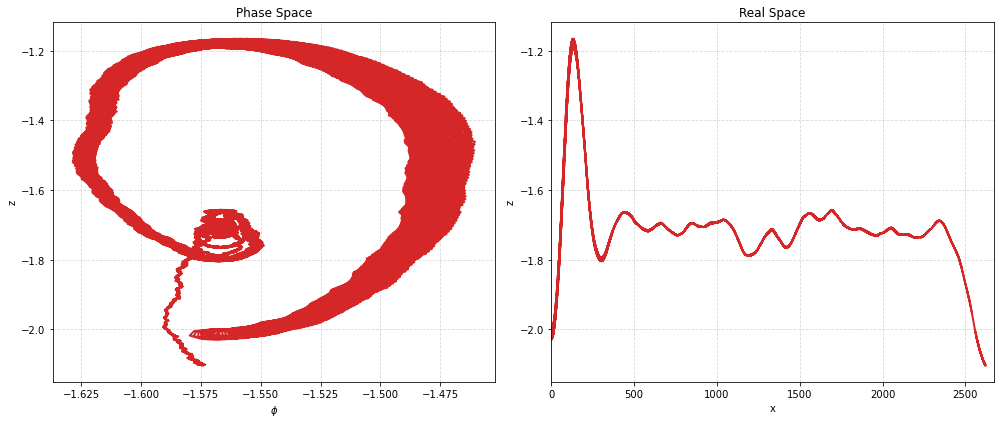

In [24]:
import numpy as np
import matplotlib.pyplot as plt

fn = 'stochastic_t3.npz'

try:
    d = np.load(fn)
    X = d['x']
    Z = d['z']
    P = d['p']
except FileNotFoundError:
    exit()

mX = np.mean(X, axis=0)
mZ = np.mean(Z, axis=0)
mP = np.mean(P, axis=0)

xlim = 2620
msk = mX <= xlim

cX = mX[msk]
cZ = mZ[msk]
cP = mP[msk]

tgt = 50000
sk = max(1, len(cX) // tgt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(cP[::sk], cZ[::sk], c='#d62728', lw=2)
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel('z')
ax1.set_title('Phase Space')
ax1.grid(True, ls='--', alpha=0.5)

ax2.plot(cX[::sk], cZ[::sk], c='#d62728', lw=2)
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_xlim(0, xlim + 50)
ax2.set_title(f'Real Space')
ax2.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.savefig('t3Stochastic_Phyto.pdf', dpi=300)
plt.show()

#### t = 40000

In [11]:
import numpy as np
import time
from numba import njit, prange
import gc

Dr = 0.00001
sig = 0.001
bet = 100
lam = 0.6
alf = 0.1
v0 = 0.01
tn = 40000
dt = 0.1
target = 1000
x0, z0, p0 = 0.0, -2.0, -0.5 * np.pi
step = 10
bsize = 500

T = np.arange(0.0, tn + 1e-6, dt, dtype=np.float32)
N = len(T)
sT = T[::step]

@njit(parallel=True, fastmath=True)
def sim(n, N, T, dt, Dr, lam, alf, sig, bet, v0):
    X = np.zeros((n, N), dtype=np.float32)
    Z = np.zeros((n, N), dtype=np.float32)
    P = np.zeros((n, N), dtype=np.float32)
    L = np.full(n, N, dtype=np.int64)
    sqdt = np.float32(np.sqrt(2 * Dr * dt))
    
    clam = np.float32(lam)
    calf = np.float32(alf)
    csig = np.float32(sig)
    cbet = np.float32(bet)
    cv0  = np.float32(v0)
    
    for i in prange(n):
        cx = np.float32(x0)
        cz = np.float32(z0)
        cp = np.float32(p0)
        
        X[i, 0], Z[i, 0], P[i, 0] = cx, cz, cp
        
        for j in range(N - 1):
            ez = np.exp(cz)
            pd = cx - T[j]
            noi = sqdt * np.float32(np.random.standard_normal())
            
            npdt = cp + (clam*calf*ez*np.cos(pd + 2*cp) + 0.5*csig*(1 + clam*np.cos(2*cp)))*dt + noi
            nx = cx + (calf*ez*np.cos(pd) + cv0*np.sin(cp) + csig*(cbet + cz))*dt
            nz = cz + (calf*ez*np.sin(pd) + cv0*np.cos(cp))*dt
            
            X[i, j+1] = nx
            Z[i, j+1] = nz
            P[i, j+1] = npdt
            
            cx, cz, cp = nx, nz, npdt
            
            if cz > 0.0 or cz < -6.0:
                L[i] = j + 2
                break
                
    return X, Z, P, L

lX, lZ, lP = [], [], []
found = 0

print(f"Start Sim (tn={tn}, bsize={bsize})")
t1 = time.time()

while found < target:
    gc.collect()
    print(f"Running batch...", end=" ")
    
    rX, rZ, rP, rL = sim(bsize, N, T, np.float32(dt), np.float32(Dr), 
                         np.float32(lam), np.float32(alf), np.float32(sig), 
                         np.float32(bet), np.float32(v0))
    
    surv = np.where(rL == N)[0]
    ns = len(surv)
    need = target - found
    take = surv[:need]
    
    for idx in take:
        lX.append(rX[idx][::step].copy())
        lZ.append(rZ[idx][::step].copy())
        lP.append(rP[idx][::step].copy())
        
    found += len(take)
    print(f"Surv: {ns}. Tot: {found}/{target}")
    
    del rX, rZ, rP, rL
    time.sleep(0.1)

fX = np.array(lX)
fZ = np.array(lZ)
fP = np.array(lP)

np.savez_compressed('stochastic_t4.npz', t=sT, x=fX, z=fZ, p=fP)
print(f"Done. Time: {time.time()-t1:.2f}s")

Start Sim (tn=40000, bsize=500)
Running batch... Surv: 2. Tot: 2/1000
Running batch... Surv: 2. Tot: 4/1000
Running batch... Surv: 1. Tot: 5/1000
Running batch... Surv: 5. Tot: 10/1000
Running batch... Surv: 4. Tot: 14/1000
Running batch... Surv: 5. Tot: 19/1000
Running batch... Surv: 1. Tot: 20/1000
Running batch... Surv: 2. Tot: 22/1000
Running batch... Surv: 3. Tot: 25/1000
Running batch... Surv: 1. Tot: 26/1000
Running batch... Surv: 3. Tot: 29/1000
Running batch... Surv: 2. Tot: 31/1000
Running batch... Surv: 0. Tot: 31/1000
Running batch... Surv: 6. Tot: 37/1000
Running batch... Surv: 2. Tot: 39/1000
Running batch... Surv: 1. Tot: 40/1000
Running batch... Surv: 2. Tot: 42/1000
Running batch... Surv: 3. Tot: 45/1000
Running batch... Surv: 1. Tot: 46/1000
Running batch... Surv: 2. Tot: 48/1000
Running batch... Surv: 3. Tot: 51/1000
Running batch... Surv: 6. Tot: 57/1000
Running batch... Surv: 4. Tot: 61/1000
Running batch... Surv: 6. Tot: 67/1000
Running batch... Surv: 2. Tot: 69/1

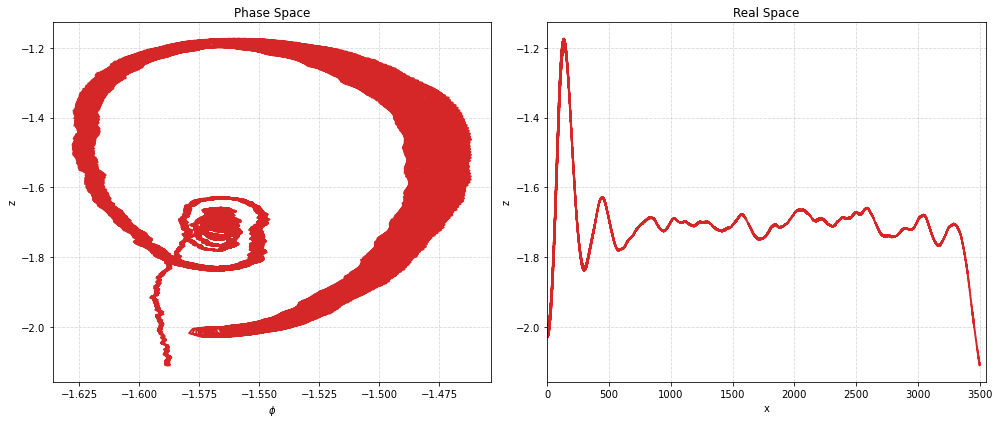

In [25]:
import numpy as np
import matplotlib.pyplot as plt

fn = 'stochastic_t4.npz'

try:
    d = np.load(fn)
    X = d['x']
    Z = d['z']
    P = d['p']
except FileNotFoundError:
    exit()

mX = np.mean(X, axis=0)
mZ = np.mean(Z, axis=0)
mP = np.mean(P, axis=0)

xlim = 3500
msk = mX <= xlim

cX = mX[msk]
cZ = mZ[msk]
cP = mP[msk]

tgt = 50000
sk = max(1, len(cX) // tgt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(cP[::sk], cZ[::sk], c='#d62728', lw=2)
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel('z')
ax1.set_title('Phase Space')
ax1.grid(True, ls='--', alpha=0.5)

ax2.plot(cX[::sk], cZ[::sk], c='#d62728', lw=2)
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_xlim(0, xlim + 50)
ax2.set_title(f'Real Space')
ax2.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.savefig('t4Stochastic_Phyto.pdf', dpi=300)
plt.show()

#### Temporal Evolution and Layer Exit
We extended the simulation across increasing time intervals ($t = 10 000$ to $40 000$). By comparing the trajectories at these different snapshots, we can observe the "leaking" effect of the system.

As time progresses, the boundary condition at $z = -6$ becomes increasingly significant. The following plot illustrates how the phytoplankton population evolves in real space, showing the progressive exit of particles from the layer over time.

#### Final Comparison

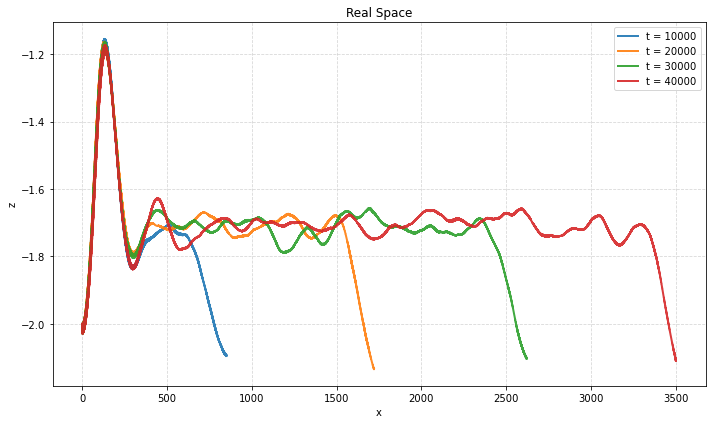

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

cfg = [
    ('stochastic_t1.npz', 850,  't = 10000'),
    ('stochastic_t2.npz', 1720, 't = 20000'),
    ('stochastic_t3.npz', 2620, 't = 30000'),
    ('stochastic_t4.npz', 3500, 't = 40000')
]

fig, ax = plt.subplots(figsize=(10, 6))

for i, (fn, xl, lb) in enumerate(cfg):
    if not os.path.exists(fn):
        continue

    try:
        d = np.load(fn)
        mx = np.mean(d['x'], axis=0)
        mz = np.mean(d['z'], axis=0)

        m = mx <= xl
        x = mx[m]
        z = mz[m]

        sk = max(1, len(x) // 50000)
        ax.plot(x[::sk], z[::sk], label=lb, lw=2, alpha=0.9)

    except:
        pass

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_title('Real Space')
ax.grid(True, ls='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.savefig('Comparison_RealSpace.pdf', dpi=300)
plt.show()

### Fokker-Planck Numerical Validation ($D_r = 0.01$)
In this final section, we perform a simulation using a larger diffusion coefficient ($D_r = 0.01$) to validate our results against the numerical solution of the **Fokker-Planck equation**.

With the biologically realistic parameter ($D_r = 10^{-5}$), the system exhibits fine-scale oscillations near equilibrium. Resolving these features via a Fokker-Planck finite difference scheme would require a grid resolution beyond our current computational resources.

By increasing $D_r$, we enter a regime where the distribution is smoother and easier to resolve. This allows us to confirm that the stochastic Monte Carlo trajectories and the deterministic Fokker-Planck evolution are in agreement, validating the numerical robustness of our approach.

In [1]:
import numpy as np
import time
from numba import njit, prange
import gc

Dr = 0.01
sig = 0.001
bet = 100
lam = 0.6
alf = 0.1
v0 = 0.01
tn = 10000
dt = 0.1
target = 1000
x0, z0, p0 = 0.0, -2.0, -0.5 * np.pi
step = 10
bsize = 1500

T = np.arange(0.0, tn + 1e-6, dt, dtype=np.float32)
N = len(T)
sT = T[::step]

@njit(parallel=True, fastmath=True)
def sim(n, N, T, dt, Dr, lam, alf, sig, bet, v0):
    X = np.zeros((n, N), dtype=np.float32)
    Z = np.zeros((n, N), dtype=np.float32)
    P = np.zeros((n, N), dtype=np.float32)
    L = np.full(n, N, dtype=np.int64)
    sqdt = np.float32(np.sqrt(2 * Dr * dt))
    
    clam = np.float32(lam)
    calf = np.float32(alf)
    csig = np.float32(sig)
    cbet = np.float32(bet)
    cv0  = np.float32(v0)
    
    for i in prange(n):
        cx = np.float32(x0)
        cz = np.float32(z0)
        cp = np.float32(p0)
        
        X[i, 0], Z[i, 0], P[i, 0] = cx, cz, cp
        
        for j in range(N - 1):
            ez = np.exp(cz)
            pd = cx - T[j]
            noi = sqdt * np.float32(np.random.standard_normal())
            
            npdt = cp + (clam*calf*ez*np.cos(pd + 2*cp) + 0.5*csig*(1 + clam*np.cos(2*cp)))*dt + noi
            nx = cx + (calf*ez*np.cos(pd) + cv0*np.sin(cp) + csig*(cbet + cz))*dt
            nz = cz + (calf*ez*np.sin(pd) + cv0*np.cos(cp))*dt
            
            X[i, j+1] = nx
            Z[i, j+1] = nz
            P[i, j+1] = npdt
            
            cx, cz, cp = nx, nz, npdt
            
            #if cz > 0.0 or cz < -6.0:
            if cz > 0.0:
                L[i] = j + 2
                break
                
    return X, Z, P, L

lX, lZ, lP = [], [], []
found = 0

print(f"Start Sim (z0={z0}, fixed batch={bsize})")
t1 = time.time()

while found < target:
    gc.collect()
    print(f"Running batch...", end=" ")
    
    rX, rZ, rP, rL = sim(bsize, N, T, np.float32(dt), np.float32(Dr), 
                         np.float32(lam), np.float32(alf), np.float32(sig), 
                         np.float32(bet), np.float32(v0))
    
    surv = np.where(rL == N)[0]
    ns = len(surv)
    need = target - found
    take = surv[:need]
    
    for idx in take:
        lX.append(rX[idx][::step])
        lZ.append(rZ[idx][::step])
        lP.append(rP[idx][::step])
        
    found += len(take)
    print(f"Surv: {ns}. Tot: {found}/{target}")
    
    del rX, rZ, rP, rL

fX = np.array(lX)
fZ = np.array(lZ)
fP = np.array(lP)

np.savez_compressed('wrong_stochastic.npz', t=sT, x=fX, z=fZ, p=fP)
print(f"Done. Time: {time.time()-t1:.2f}s")

Start Sim (z0=-2.0, fixed batch=1500)
Running batch... Surv: 313. Tot: 313/1000
Running batch... Surv: 351. Tot: 664/1000
Running batch... Surv: 351. Tot: 1000/1000
Done. Time: 48.68s


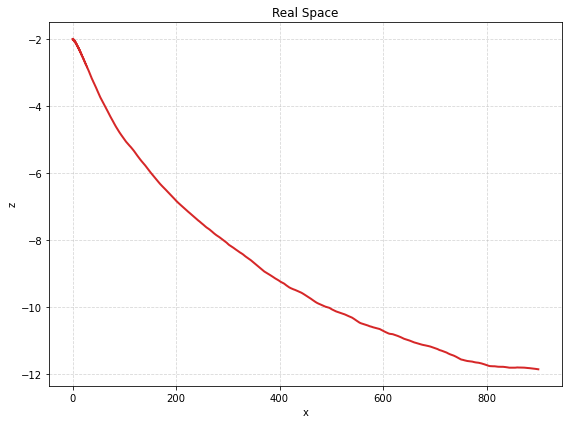

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fn = 'wrong_stochastic.npz'
xlim = 900

try:
    d = np.load(fn)
    mx = np.mean(d['x'], axis=0)
    mz = np.mean(d['z'], axis=0)
except:
    exit()

m = mx <= xlim
x = mx[m]
z = mz[m]

sk = max(1, len(x) // 50000)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x[::sk], z[::sk], c='#d62728', lw=2)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_title('Real Space')
ax.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.savefig('wrong_stochastic_phyto.pdf', dpi=300)
plt.show()